In [45]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

In [46]:
targets = ["target_CHEMBL240",
          "target_CHEMBL260",
          "target_CHEMBL279"]

methods = ["RF", "xgboost", "MLP"]


sorting = [True, False]

sorting_vars = ["logp"] #, "pchembl"]

druglike = [True, False]

In [47]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [48]:

# DataFrame to store all results
results_df = pd.DataFrame(columns=['Target', 'Variable', 'Method', 'Batch', 'evalt', 'Low Similarity Count', 'Novelty Error'])

# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("sortedFCV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/{var}_sorted_fcv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/{var}_sorted_fcv_results_{method}_training batches.csv")
            
            # Precompute fingerprints for training set
            train_df['Fingerprint'] = train_df['Standardized_SMILES'].parallel_apply(
                lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2)
            )

            # Function to find max similarity with batch optimization
            def max_tanimoto(test_smile, train_fps):
                test_mol = Chem.MolFromSmiles(test_smile)
                test_fp = AllChem.GetMorganFingerprintAsBitVect(test_mol, radius=2)
                return max(DataStructs.TanimotoSimilarity(test_fp, train_fp) for train_fp in train_fps)

            # Analyze each batch
            for batch in test_df['testing batch'].unique():
                test_batch = test_df[test_df['testing batch'] == batch]
                train_batch = train_df[train_df['training batch'] == batch]
                train_fps = train_batch['Fingerprint'].tolist()

                low_similarity_smiles = []
                errors = []

                for idx, test_row in test_batch.iterrows():
                    max_similarity = max_tanimoto(test_row['Standardized_SMILES'], train_fps)
                    
                    if max_similarity < 0.55:
                        low_similarity_smiles.append(test_row['Standardized_SMILES'])
                        error = abs(test_row['True Values'] - test_row['Predictions'])
                        errors.append(error)

                # Calculate the average error for low similarity compounds
                average_error = np.mean(errors) if errors else 0
                
                print(f"Batch {batch}: Number of low similarity SMILES = {len(low_similarity_smiles)}, Average Error = {average_error:.2f}")
    
    
                results_df = results_df.append({
                    'Target': target,
                    'Variable': var,
                    'Method': method,
                    'Batch': batch,
                    'evalt': "sorted_fcv",
                    'Low Similarity Count': len(low_similarity_smiles),
                    'Novelty Error': average_error
                }, ignore_index=True)

# Optionally, save the results DataFrame to a CSV file
results_df.to_csv('novelty_error_sorted_fcv_results.csv', index=False)

# Display the results DataFrame
results_df

sortedFCV
target_CHEMBL240
RF
logp
Batch 1: Number of low similarity SMILES = 18, Average Error = 0.53
Batch 2: Number of low similarity SMILES = 14, Average Error = 0.68
Batch 3: Number of low similarity SMILES = 33, Average Error = 1.18
Batch 4: Number of low similarity SMILES = 27, Average Error = 0.61
Batch 5: Number of low similarity SMILES = 19, Average Error = 0.78
Batch 6: Number of low similarity SMILES = 9, Average Error = 0.85
Batch 7: Number of low similarity SMILES = 16, Average Error = 0.66
Batch 8: Number of low similarity SMILES = 3, Average Error = 0.28
Batch 9: Number of low similarity SMILES = 31, Average Error = 1.34
sortedFCV
target_CHEMBL240
xgboost
logp
Batch 1: Number of low similarity SMILES = 18, Average Error = 0.56
Batch 2: Number of low similarity SMILES = 14, Average Error = 0.69
Batch 3: Number of low similarity SMILES = 33, Average Error = 1.07
Batch 4: Number of low similarity SMILES = 27, Average Error = 0.66
Batch 5: Number of low similarity SMILES = 

,Target,Variable,Method,Batch,evalt,Low Similarity Count,Novelty Error
0,target_CHEMBL240,logp,RF,1,sorted_fcv,18,0.530934
1,target_CHEMBL240,logp,RF,2,sorted_fcv,14,0.677165
2,target_CHEMBL240,logp,RF,3,sorted_fcv,33,1.179075
3,target_CHEMBL240,logp,RF,4,sorted_fcv,27,0.609007
4,target_CHEMBL240,logp,RF,5,sorted_fcv,19,0.783379
...,...,...,...,...,...,...,...
76,target_CHEMBL279,logp,MLP,5,sorted_fcv,16,1.192487
77,target_CHEMBL279,logp,MLP,6,sorted_fcv,16,1.480092
78,target_CHEMBL279,logp,MLP,7,sorted_fcv,17,1.067456
79,target_CHEMBL279,logp,MLP,8,sorted_fcv,31,1.359261


In [49]:

# DataFrame to store all results
results_df = pd.DataFrame(columns=['Target', 'Variable', 'Method', 'Batch', 'evalt', 'Low Similarity Count', 'Novelty Error'])

# Loop through each configuration
for target in targets:
    for method in methods:
        print("unsortedFCV")
        print(target)
        print(method)
        print(var)

        # Load the DataFrame from a CSV file
        test_df = pd.read_csv(f"../{target}-1_results/unsorted_fcv_results_{method}_testing batches.csv")
        train_df = pd.read_csv(f"../{target}-1_results/unsorted_fcv_results_{method}_training batches.csv")

        # Precompute fingerprints for training set
        train_df['Fingerprint'] = train_df['Standardized_SMILES'].parallel_apply(
            lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2)
        )

        # Function to find max similarity with batch optimization
        def max_tanimoto(test_smile, train_fps):
            test_mol = Chem.MolFromSmiles(test_smile)
            test_fp = AllChem.GetMorganFingerprintAsBitVect(test_mol, radius=2)
            return max(DataStructs.TanimotoSimilarity(test_fp, train_fp) for train_fp in train_fps)

        # Analyze each batch
        for batch in test_df['testing batch'].unique():
            test_batch = test_df[test_df['testing batch'] == batch]
            train_batch = train_df[train_df['training batch'] == batch]
            train_fps = train_batch['Fingerprint'].tolist()

            low_similarity_smiles = []
            errors = []

            for idx, test_row in test_batch.iterrows():
                max_similarity = max_tanimoto(test_row['Standardized_SMILES'], train_fps)

                if max_similarity < 0.55:
                    low_similarity_smiles.append(test_row['Standardized_SMILES'])
                    error = abs(test_row['True Values'] - test_row['Predictions'])
                    errors.append(error)

            # Calculate the average error for low similarity compounds
            average_error = np.mean(errors) if errors else 0

            print(f"Batch {batch}: Number of low similarity SMILES = {len(low_similarity_smiles)}, Average Error = {average_error:.2f}")


            results_df = results_df.append({
                'Target': target,
                'Variable': "None",
                'Method': method,
                'Batch': batch,
                'evalt': "unsorted_fcv",
                'Low Similarity Count': len(low_similarity_smiles),
                'Novelty Error': average_error
            }, ignore_index=True)

# Optionally, save the results DataFrame to a CSV file
results_df.to_csv('novelty_error_unsorted_fcv_results.csv', index=False)

# Display the results DataFrame
results_df

unsortedFCV
target_CHEMBL240
RF
logp
Batch 1: Number of low similarity SMILES = 53, Average Error = 0.59
Batch 2: Number of low similarity SMILES = 37, Average Error = 0.37
Batch 3: Number of low similarity SMILES = 42, Average Error = 0.59
Batch 4: Number of low similarity SMILES = 23, Average Error = 0.59
Batch 5: Number of low similarity SMILES = 13, Average Error = 0.93
Batch 6: Number of low similarity SMILES = 13, Average Error = 0.39
Batch 7: Number of low similarity SMILES = 10, Average Error = 0.55
Batch 8: Number of low similarity SMILES = 11, Average Error = 0.83
Batch 9: Number of low similarity SMILES = 12, Average Error = 0.85
unsortedFCV
target_CHEMBL240
xgboost
logp
Batch 1: Number of low similarity SMILES = 53, Average Error = 0.55
Batch 2: Number of low similarity SMILES = 37, Average Error = 0.36
Batch 3: Number of low similarity SMILES = 42, Average Error = 0.57
Batch 4: Number of low similarity SMILES = 23, Average Error = 0.29
Batch 5: Number of low similarity SMI

,Target,Variable,Method,Batch,evalt,Low Similarity Count,Novelty Error
0,target_CHEMBL240,None,RF,1,unsorted_fcv,53,0.591407
1,target_CHEMBL240,None,RF,2,unsorted_fcv,37,0.367804
2,target_CHEMBL240,None,RF,3,unsorted_fcv,42,0.586253
3,target_CHEMBL240,None,RF,4,unsorted_fcv,23,0.592796
4,target_CHEMBL240,None,RF,5,unsorted_fcv,13,0.927446
...,...,...,...,...,...,...,...
76,target_CHEMBL279,None,MLP,5,unsorted_fcv,6,1.342942
77,target_CHEMBL279,None,MLP,6,unsorted_fcv,2,0.575263
78,target_CHEMBL279,None,MLP,7,unsorted_fcv,7,0.743431
79,target_CHEMBL279,None,MLP,8,unsorted_fcv,1,1.631556


In [50]:

# DataFrame to store all results
results_df = pd.DataFrame(columns=['Target', 'Variable', 'Method', 'Batch', 'evalt', 'Low Similarity Count', 'Novelty Error'])

# Loop through each configuration
for target in targets:
    for method in methods:
        print("CV")
        print(target)
        print(method)
        print(var)

        # Load the DataFrame from a CSV file
        test_df = pd.read_csv(f"../{target}-1_results/cv_results_{method}_testing batches.csv")
        train_df = pd.read_csv(f"../{target}-1_results/cv_results_{method}_training batches.csv")

        # Precompute fingerprints for training set
        train_df['Fingerprint'] = train_df['Standardized_SMILES'].parallel_apply(
            lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2)
        )

        # Function to find max similarity with batch optimization
        def max_tanimoto(test_smile, train_fps):
            test_mol = Chem.MolFromSmiles(test_smile)
            test_fp = AllChem.GetMorganFingerprintAsBitVect(test_mol, radius=2)
            return max(DataStructs.TanimotoSimilarity(test_fp, train_fp) for train_fp in train_fps)

        # Analyze each batch
        for batch in test_df['testing batch'].unique():
            test_batch = test_df[test_df['testing batch'] == batch]
            train_batch = train_df[train_df['training batch'] == batch]
            train_fps = train_batch['Fingerprint'].tolist()

            low_similarity_smiles = []
            errors = []

            for idx, test_row in test_batch.iterrows():
                max_similarity = max_tanimoto(test_row['Standardized_SMILES'], train_fps)

                if max_similarity < 0.55:
                    low_similarity_smiles.append(test_row['Standardized_SMILES'])
                    error = abs(test_row['True Values'] - test_row['Predictions'])
                    errors.append(error)

            # Calculate the average error for low similarity compounds
            average_error = np.mean(errors) if errors else 0

            print(f"Batch {batch}: Number of low similarity SMILES = {len(low_similarity_smiles)}, Average Error = {average_error:.2f}")


            results_df = results_df.append({
                'Target': target,
                'Variable': "None",
                'Method': method,
                'Batch': batch,
                'evalt': "CV",
                'Low Similarity Count': len(low_similarity_smiles),
                'Novelty Error': average_error
            }, ignore_index=True)

# Optionally, save the results DataFrame to a CSV file
results_df.to_csv('novelty_error_cv_results.csv', index=False)

# Display the results DataFrame
results_df

CV
target_CHEMBL240
RF
logp
Batch 1: Number of low similarity SMILES = 2, Average Error = 0.82
Batch 2: Number of low similarity SMILES = 2, Average Error = 0.34
Batch 3: Number of low similarity SMILES = 1, Average Error = 0.08
Batch 4: Number of low similarity SMILES = 3, Average Error = 0.53
Batch 5: Number of low similarity SMILES = 3, Average Error = 0.80
Batch 6: Number of low similarity SMILES = 1, Average Error = 1.77
Batch 7: Number of low similarity SMILES = 2, Average Error = 0.26
Batch 8: Number of low similarity SMILES = 5, Average Error = 1.30
Batch 9: Number of low similarity SMILES = 4, Average Error = 0.96
Batch 10: Number of low similarity SMILES = 1, Average Error = 0.55
CV
target_CHEMBL240
xgboost
logp
Batch 1: Number of low similarity SMILES = 2, Average Error = 0.84
Batch 2: Number of low similarity SMILES = 2, Average Error = 0.28
Batch 3: Number of low similarity SMILES = 1, Average Error = 0.06
Batch 4: Number of low similarity SMILES = 3, Average Error = 0.73


,Target,Variable,Method,Batch,evalt,Low Similarity Count,Novelty Error
0,target_CHEMBL240,None,RF,1,CV,2,0.821700
1,target_CHEMBL240,None,RF,2,CV,2,0.339800
2,target_CHEMBL240,None,RF,3,CV,1,0.082400
3,target_CHEMBL240,None,RF,4,CV,3,0.527933
4,target_CHEMBL240,None,RF,5,CV,3,0.797800
...,...,...,...,...,...,...,...
85,target_CHEMBL279,None,MLP,6,CV,3,0.833562
86,target_CHEMBL279,None,MLP,7,CV,4,0.627465
87,target_CHEMBL279,None,MLP,8,CV,3,1.070830
88,target_CHEMBL279,None,MLP,9,CV,2,0.229570


In [51]:

# DataFrame to store all results
results_df = pd.DataFrame(columns=['Target', 'Variable', 'Method', 'Batch', 'evalt', 'Low Similarity Count', 'Novelty Error'])

# Loop through each configuration
for target in targets:
    for method in methods:
        print("CV")
        print(target)
        print(method)
        print(var)

        # Load the DataFrame from a CSV file
        test_df = pd.read_csv(f"../{target}-1_results/scaffold_cv_results_{method}_testing batches.csv")
        train_df = pd.read_csv(f"../{target}-1_results/scaffold_cv_results_{method}_training batches.csv")

        # Precompute fingerprints for training set
        train_df['Fingerprint'] = train_df['Standardized_SMILES'].parallel_apply(
            lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2)
        )

        # Function to find max similarity with batch optimization
        def max_tanimoto(test_smile, train_fps):
            test_mol = Chem.MolFromSmiles(test_smile)
            test_fp = AllChem.GetMorganFingerprintAsBitVect(test_mol, radius=2)
            return max(DataStructs.TanimotoSimilarity(test_fp, train_fp) for train_fp in train_fps)

        # Analyze each batch
        for batch in test_df['testing batch'].unique():
            test_batch = test_df[test_df['testing batch'] == batch]
            train_batch = train_df[train_df['training batch'] == batch]
            train_fps = train_batch['Fingerprint'].tolist()

            low_similarity_smiles = []
            errors = []

            for idx, test_row in test_batch.iterrows():
                max_similarity = max_tanimoto(test_row['Standardized_SMILES'], train_fps)

                if max_similarity < 0.55:
                    low_similarity_smiles.append(test_row['Standardized_SMILES'])
                    error = abs(test_row['True Values'] - test_row['Predictions'])
                    errors.append(error)

            # Calculate the average error for low similarity compounds
            average_error = np.mean(errors) if errors else 0

            print(f"Batch {batch}: Number of low similarity SMILES = {len(low_similarity_smiles)}, Average Error = {average_error:.2f}")


            results_df = results_df.append({
                'Target': target,
                'Variable': "None",
                'Method': method,
                'Batch': batch,
                'evalt': "scaffold_CV",
                'Low Similarity Count': len(low_similarity_smiles),
                'Novelty Error': average_error
            }, ignore_index=True)

# Optionally, save the results DataFrame to a CSV file
results_df.to_csv('novelty_error_scaffold_cv_results.csv', index=False)

# Display the results DataFrame
results_df

CV
target_CHEMBL240
RF
logp
Batch 1: Number of low similarity SMILES = 9, Average Error = 2.95
Batch 2: Number of low similarity SMILES = 55, Average Error = 0.39
Batch 3: Number of low similarity SMILES = 9, Average Error = 0.36
Batch 4: Number of low similarity SMILES = 4, Average Error = 0.60
Batch 5: Number of low similarity SMILES = 2, Average Error = 0.10
Batch 6: Number of low similarity SMILES = 5, Average Error = 0.53
Batch 7: Number of low similarity SMILES = 5, Average Error = 0.52
Batch 8: Number of low similarity SMILES = 21, Average Error = 0.73
Batch 9: Number of low similarity SMILES = 7, Average Error = 1.10
Batch 10: Number of low similarity SMILES = 10, Average Error = 0.92
CV
target_CHEMBL240
xgboost
logp
Batch 1: Number of low similarity SMILES = 9, Average Error = 3.00
Batch 2: Number of low similarity SMILES = 55, Average Error = 0.35
Batch 3: Number of low similarity SMILES = 9, Average Error = 0.38
Batch 4: Number of low similarity SMILES = 4, Average Error = 0

,Target,Variable,Method,Batch,evalt,Low Similarity Count,Novelty Error
0,target_CHEMBL240,None,RF,1,scaffold_CV,9,2.945800
1,target_CHEMBL240,None,RF,2,scaffold_CV,55,0.389004
2,target_CHEMBL240,None,RF,3,scaffold_CV,9,0.358267
3,target_CHEMBL240,None,RF,4,scaffold_CV,4,0.597900
4,target_CHEMBL240,None,RF,5,scaffold_CV,2,0.104000
...,...,...,...,...,...,...,...
85,target_CHEMBL279,None,MLP,6,scaffold_CV,16,1.139647
86,target_CHEMBL279,None,MLP,7,scaffold_CV,19,0.702953
87,target_CHEMBL279,None,MLP,8,scaffold_CV,11,0.511511
88,target_CHEMBL279,None,MLP,9,scaffold_CV,11,0.998548


In [52]:

ne_sortedforwardCV = pd.read_csv("novelty_error_sorted_fcv_results.csv")
ne_unsortedforwardCV = pd.read_csv("novelty_error_unsorted_fcv_results.csv")
ne_CV = pd.read_csv("novelty_error_cv_results.csv")
ne_scaffold_CV = pd.read_csv("novelty_error_scaffold_cv_results.csv")

# Concatenating the DataFrames
combined_metrics = pd.concat([ne_sortedforwardCV, ne_unsortedforwardCV, ne_CV, ne_scaffold_CV], axis=0)

# Optional: Reset index if you want a clean, sequential index in the new DataFrame
combined_metrics.reset_index(drop=True, inplace=True)

# Save the concatenated DataFrame to a CSV file
combined_metrics.to_csv('combined_novelty_error.csv', index=False)

# Display the DataFrame to verify the contents
combined_metrics


,Target,Variable,Method,Batch,evalt,Low Similarity Count,Novelty Error
0,target_CHEMBL240,logp,RF,1,sorted_fcv,18,0.530934
1,target_CHEMBL240,logp,RF,2,sorted_fcv,14,0.677165
2,target_CHEMBL240,logp,RF,3,sorted_fcv,33,1.179075
3,target_CHEMBL240,logp,RF,4,sorted_fcv,27,0.609007
4,target_CHEMBL240,logp,RF,5,sorted_fcv,19,0.783379
...,...,...,...,...,...,...,...
337,target_CHEMBL279,None,MLP,6,scaffold_CV,16,1.139647
338,target_CHEMBL279,None,MLP,7,scaffold_CV,19,0.702953
339,target_CHEMBL279,None,MLP,8,scaffold_CV,11,0.511511
340,target_CHEMBL279,None,MLP,9,scaffold_CV,11,0.998548


In [53]:
filtered_df = combined_metrics[combined_metrics["Method"]=="RF"]
filtered_df

,Target,Variable,Method,Batch,evalt,Low Similarity Count,Novelty Error
0,target_CHEMBL240,logp,RF,1,sorted_fcv,18,0.530934
1,target_CHEMBL240,logp,RF,2,sorted_fcv,14,0.677165
2,target_CHEMBL240,logp,RF,3,sorted_fcv,33,1.179075
3,target_CHEMBL240,logp,RF,4,sorted_fcv,27,0.609007
4,target_CHEMBL240,logp,RF,5,sorted_fcv,19,0.783379
...,...,...,...,...,...,...,...
317,target_CHEMBL279,None,RF,6,scaffold_CV,16,1.109575
318,target_CHEMBL279,None,RF,7,scaffold_CV,19,0.574495
319,target_CHEMBL279,None,RF,8,scaffold_CV,11,0.827718
320,target_CHEMBL279,None,RF,9,scaffold_CV,11,1.066345


In [55]:
filtered_df[["evalt", "Novelty Error"]].groupby("evalt").describe()

Novelty Error                                                    \
                     count      mean       std       min       25%       50%   
evalt                                                                          
CV                    30.0  0.803699  0.414506  0.000000  0.511633  0.818550   
scaffold_CV           30.0  0.804781  0.484452  0.104000  0.535619  0.731774   
sorted_fcv            27.0  0.837274  0.223303  0.284067  0.686336  0.848533   
unsorted_fcv          27.0  0.786612  0.306328  0.197200  0.569898  0.829232   

                                  
                   75%       max  
evalt                             
CV            1.118750  1.773000  
scaffold_CV   0.920053  2.945800  
sorted_fcv    0.948002  1.336323  
unsorted_fcv  0.935101  1.644000

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CV vs. scaffold_CV: Levene test of variance, P_val:6.092e-01 Stat=2.642e-01
unsorted_fcv vs. CV: Levene test of variance, P_val:7.922e-02 Stat=3.198e+00
sorted_fcv vs. unsorted_fcv: Levene test of variance, P_val:2.146e-01 Stat=1.578e+00
sorted_fcv vs. CV: Levene test of variance, P_val:2.711e-03 Stat=9.865e+00
unsorted_fcv vs. scaffold_CV: Levene test of variance, P_val:4.541e-01 Stat=5.684e-01
sorted_fcv vs. scaffold_CV: Levene test of variance, P_val:1.243e-01 Stat=2.436e+00


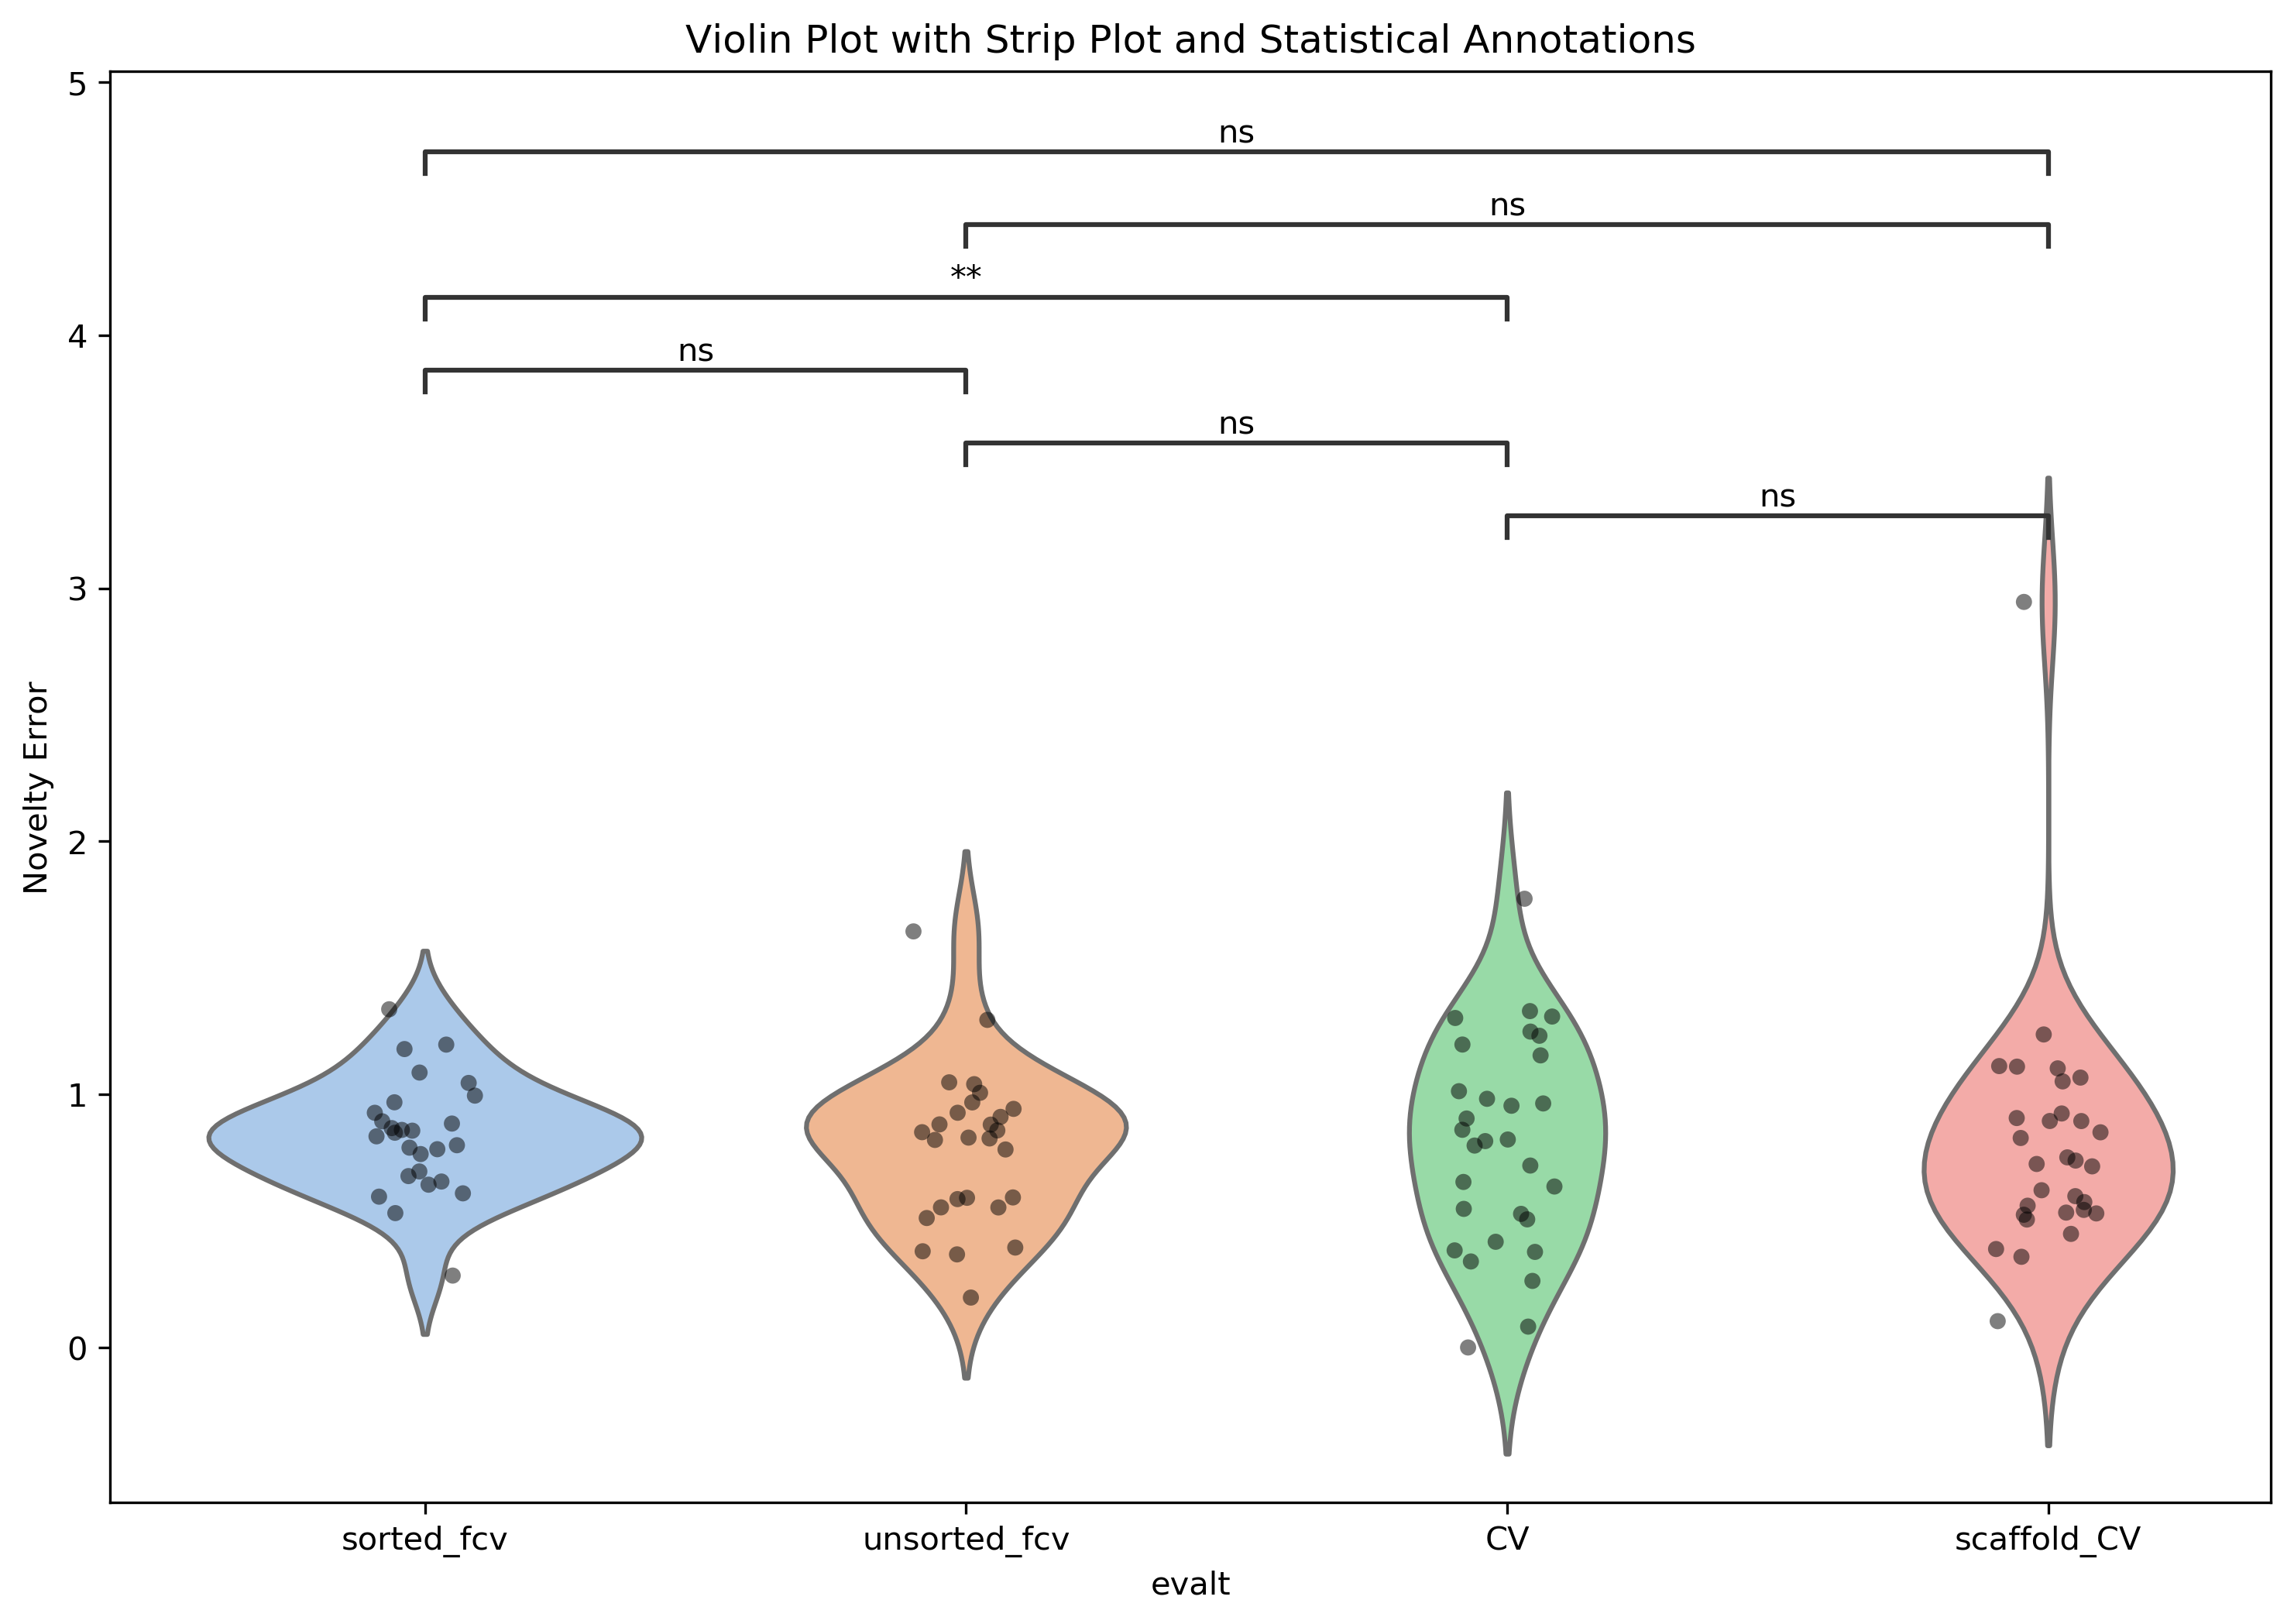

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import levene

# Set up the matplotlib figure
plt.figure(figsize=(12, 8), dpi=300)

# Define the order of categories
order = ["sorted_fcv", "unsorted_fcv", "CV", "scaffold_CV"]

# Create violin plot with strip plot overlay
sns.violinplot(x="evalt", y="Novelty Error", data=filtered_df, inner=None, palette="pastel", order=order)
sns.stripplot(x="evalt", y="Novelty Error", data=filtered_df, jitter=True, color="black", alpha=0.5, order=order)

# Define pairs for statistical comparison
pairs = [
    ("CV", "scaffold_CV"),
    ("CV", "sorted_fcv"),
    ("CV", "unsorted_fcv"),
    ("scaffold_CV", "sorted_fcv"),
    ("scaffold_CV", "unsorted_fcv"),
    ("sorted_fcv", "unsorted_fcv")
]

# Create the annotator object
annotator = Annotator(plt.gca(), pairs, data=filtered_df, x="evalt", y="Novelty Error", order=order)

# Perform t-test and add annotations
annotator.configure(test='Levene', text_format='star', loc='inside')
annotator.apply_and_annotate()

# Display the plot
plt.title("Violin Plot with Strip Plot and Statistical Annotations")
plt.show()
